# ML HA-2 #
## by Ivan Senilov (1787618) ##

The goal of this HA is to create an images classifier for boats navigating in Venice, Italy. The [MarDCT dataset](http://www.dis.uniroma1.it/~labrococo/MAR/classification.htm) [1] is used for the purpose and needs to be unzipped in the working directory.

Let's import libraries for working with data:

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

Load the data and look how much instances of each class in it. The most represented class (besides water snapshot) is the "Vaporetto ACTV". We will take it for our one-vs-all classifier (not because it is easier to implement but because the dataset is not consistent in terms of class names in training and testing sets). The multiclass classifier was realized by me in HW1, so it shouldn't create any difficulties in case of consistent label names.

In [2]:
# %%time
test_data = pd.read_csv("sc5-2013-Mar-Apr-Test-20130412/ground_truth.txt", sep=";", header=None)

test_data = test_data.set_index(0) 
test_data[1].value_counts()

# types = sorted([i.replace(" ", "").replace(":", "") for i in test_data[1].value_counts().index.values.tolist()])


Snapshot Acqua                     420
Vaporetto ACTV                     325
Mototopo                           274
Lancia: fino 10 m Bianca           217
Snapshot Barca Multipla            171
Lancia: fino 10 m Marrone          125
Snapshot Barca Parziale            116
Patanella                           74
Motobarca                           59
Barchino                            51
Topa                                29
Ambulanza                           22
Raccolta rifiuti                    19
Alilaguna                           19
Polizia                             15
Mototopo corto                      10
Lancia: fino 10 m                    7
Lancia: maggiore di 10 m Bianca      6
Motopontone rettangolare             3
Sandolo a remi                       3
Gondola                              3
Motoscafo ACTV                       1
Name: 1, dtype: int64

Populating test set with pictures according to given `.csv` file.

The pictures are resized from original shape of `(240, 800, 3)` to 10-times smaller `(24, 80, 3)` due to memory constraints. Alternatively, we could use Python generator to train model on batches to avoid loading the full dataset in RAM.

In [4]:
import os
from imageio import imread
from skimage.transform import resize
from keras.utils import to_categorical

X_test = []
Y_test = []

for filename in test_data.index.values: # os.listdir("sc5-2013-Mar-Apr-Test-20130412/"):
    if filename.endswith(".jpg"):   
        X_test.append(resize(imread(os.path.join("sc5-2013-Mar-Apr-Test-20130412/", filename)), (24,80), mode='reflect'))
        if (test_data[1][filename] == "Vaporetto ACTV"):
            Y_test.append(1)
        else:
            Y_test.append(0)

X_test = np.array(X_test)
Y_test = np.array(Y_test)
Y_test = to_categorical(Y_test)

Using TensorFlow backend.


Let's have a look at several pictures from the loaded set:

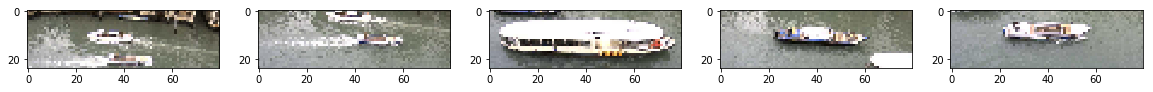

In [5]:
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(X_test[100:105]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)

Loading training dataset, resizing images and labeling respective boats as described above.

In [6]:
X_train = []
Y_train = []

for dirname in os.listdir("sc5/"):
    dirn = os.path.join("sc5/", dirname)
    if os.path.isdir(dirn):
        for filename in os.listdir(dirn):
            X_train.append(resize(imread(os.path.join(dirn, filename)), (24,80), mode='reflect'))
            if dirname == "VaporettoACTV":
                Y_train.append(1)
            else:
                Y_train.append(0)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

Y_train = to_categorical(Y_train)

Lets write short callback for recording the progress during the training. Basically, it evaluates the model after each epoch on test data and we will be able look at the graphs later on.

In [10]:
from keras.callbacks import Callback

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        log_filename = "log.csv"
        with open(log_filename, "a") as log:
            log.write("{},{},{},{},{}\n".format(epoch, loss, acc, logs["loss"], logs["acc"]))
            

testCallback = TestCallback((X_test, Y_test))

First we try simple Convolutional Neural Network with 2 layers, 16 filters in each with 4x4 kernel size.

In [13]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, Dense, Dropout, GlobalMaxPooling2D
from sklearn.metrics import classification_report

model = Sequential()
model.add(Conv2D(16, 4, activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(16, 4, activation='relu'))
model.add(GlobalMaxPooling2D())
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

model.fit(X_train, Y_train, epochs=100, batch_size=128, verbose=0, callbacks=[testCallback])
Y_pred = to_categorical(np.argmax(model.predict(X_test),axis=-1))
print("Accuracy", model.evaluate(X_test, Y_test, batch_size=128, verbose=0)[1], "\n\n")
print(classification_report(Y_test, Y_pred), "\n\n")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 21, 77, 16)        784       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 74, 16)        4112      
_________________________________________________________________
global_max_pooling2d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________
Accuracy 0.959878110958 


             precision    recall  f1-score   support

          0       0.99      0.96      0.98      1644
          1       0.82      0.97      0.89       325

avg / total       0.97      0.96      0.96      1969
 




Simple Convolutional Neural Network with 3 layers gives us 97% accuracy but only 82% precision w.r.t. target class due to unbalanced dataset.

Let's look at the graphs of loss and accuracy during the training.

<img src="chart.png">

Apparently, there is an evidence of overfitting. Let's try to make network a little bit deeper and add regularization (dropout).

In [19]:
from keras.layers import MaxPooling2D

model = Sequential()
model.add(Conv2D(16, 2, activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(16, 4, activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(32, 4, activation='relu'))
model.add(GlobalMaxPooling2D())
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

model.fit(X_train, Y_train, epochs=100, batch_size=128, verbose=0, callbacks=[testCallback])
Y_pred = to_categorical(np.argmax(model.predict(X_test),axis=-1))
print("Accuracy", model.evaluate(X_test, Y_test, batch_size=128, verbose=0)[1], "\n\n")
print(classification_report(Y_test, Y_pred), "\n\n")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 23, 79, 16)        208       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 11, 39, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 11, 39, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 36, 16)         4112      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 18, 16)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 4, 18, 16)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 1, 15, 32)         8224      
__________

There is clear improvement in accuracy and especially in recall, let's look at the graph for this network.

<img src="chart-1.png">

As seen from the second graph, the model still overfits but less and we can call it improvement.

## Conclusion ##

In this work, I explored the MarDCT dataset and built the classifier which can recognize on particular boat among many others. Two CNN architectures were tested and it was shown that regularization and deepening of network improves classification performance.

References:

1. Bloisi, Domenico D.; Iocchi, Luca; Pennisi, Andrea; Tombolini, Luigi, "ARGOS-Venice Boat Classification," in 12th IEEE International Conference on Advanced Video and Signal Based Surveillance (AVSS), 2015, pp.1-6, 2015. doi: 10.1109/AVSS.2015.7301727 